In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
(df.isnull().sum()/len(df)).sort_values(ascending=False)[:20]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
dtype: float64

In [7]:
# we have 81 features and removing the features with more than 80% missing values as they dont help in any anlysis.

In [8]:
df.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)

In [11]:
df.drop(['Id'],axis=1,inplace=True)

Text(0.5, 1.0, 'Sale Price distribution')

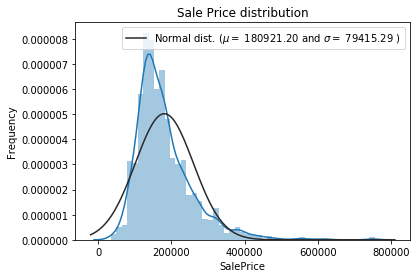

In [16]:
sns.distplot(df['SalePrice'] , fit=norm);
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'log(Sale Price+1) distribution')

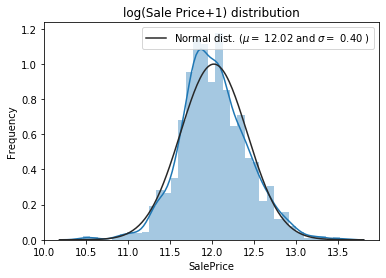

In [23]:
sns.distplot(np.log1p(df['SalePrice']) , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(df['SalePrice']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(Sale Price+1) distribution')

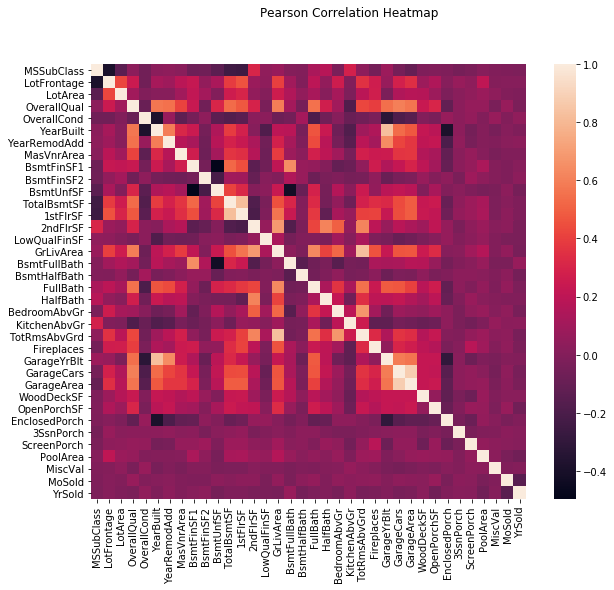

In [24]:
# corerelation between numeric features
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['SalePrice'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

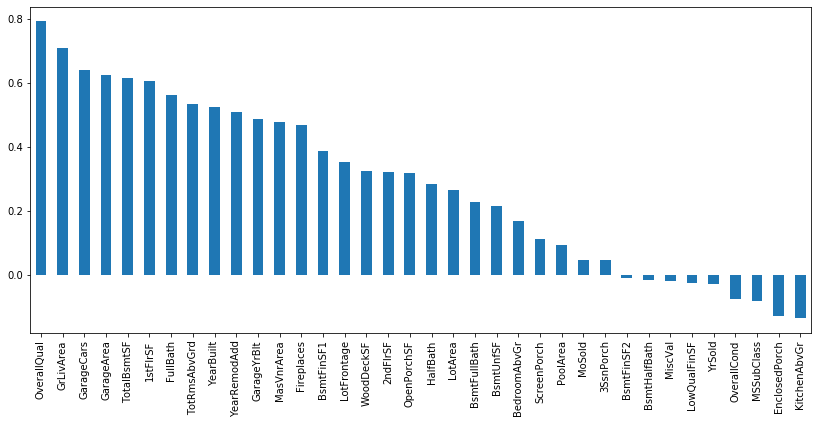

In [25]:
# corelation with target variable
corr_with_sale_price = df.corr()["SalePrice"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_sale_price.drop("SalePrice").plot.bar()
plt.show();

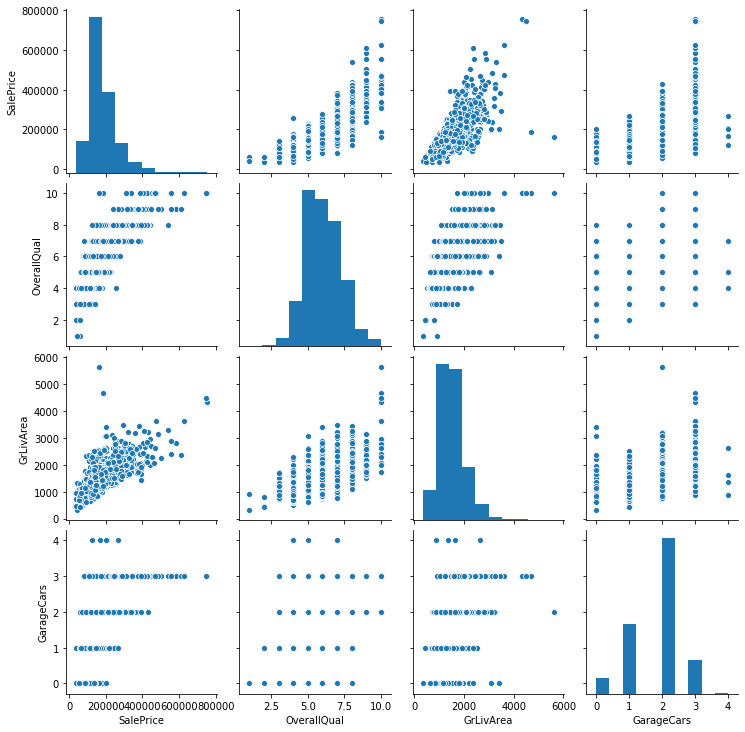

In [26]:
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']])
plt.show();

In [28]:
df['SalePrice']=np.log1p(df['SalePrice'])

In [29]:
numerical_features=df.dtypes[df.dtypes!=object].index

In [30]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [34]:
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 76, dtype: object

In [37]:
#Identifying the skewness in Numerical features and applying the log transformations.
skewed_features=df[numerical_features].apply(lambda x :skew(x.dropna()))

In [38]:
skewed_features

MSSubClass        1.41
LotFrontage       2.16
LotArea          12.20
OverallQual       0.22
OverallCond       0.69
YearBuilt        -0.61
YearRemodAdd     -0.50
MasVnrArea        2.67
BsmtFinSF1        1.68
BsmtFinSF2        4.25
BsmtUnfSF         0.92
TotalBsmtSF       1.52
1stFlrSF          1.38
2ndFlrSF          0.81
LowQualFinSF      9.00
GrLivArea         1.37
BsmtFullBath      0.60
BsmtHalfBath      4.10
FullBath          0.04
HalfBath          0.68
BedroomAbvGr      0.21
KitchenAbvGr      4.48
TotRmsAbvGrd      0.68
Fireplaces        0.65
GarageYrBlt      -0.65
GarageCars       -0.34
GarageArea        0.18
WoodDeckSF        1.54
OpenPorchSF       2.36
EnclosedPorch     3.09
3SsnPorch        10.29
ScreenPorch       4.12
PoolArea         14.81
MiscVal          24.45
MoSold            0.21
YrSold            0.10
SalePrice         0.12
dtype: float64

In [39]:
skew_modified=skewed_features[skewed_features>0.75] # selecting the skewed features greater than 0.75

In [40]:
skew_modified

MSSubClass        1.41
LotFrontage       2.16
LotArea          12.20
MasVnrArea        2.67
BsmtFinSF1        1.68
BsmtFinSF2        4.25
BsmtUnfSF         0.92
TotalBsmtSF       1.52
1stFlrSF          1.38
2ndFlrSF          0.81
LowQualFinSF      9.00
GrLivArea         1.37
BsmtHalfBath      4.10
KitchenAbvGr      4.48
WoodDeckSF        1.54
OpenPorchSF       2.36
EnclosedPorch     3.09
3SsnPorch        10.29
ScreenPorch       4.12
PoolArea         14.81
MiscVal          24.45
dtype: float64

In [41]:
skew_feats=skew_modified.index

In [42]:
skew_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [45]:
df[skew_feats] = np.log1p(df[skew_feats])

In [46]:
#converting the categorical attributes to dummy variables using pandas dummies and filling na values with mean.
df = pd.get_dummies(df)
df = df.fillna(df.mean())

In [47]:
X, y = df.drop(['SalePrice'], axis = 1), df['SalePrice']

In [48]:
X.shape

(1460, 275)

In [49]:
y.shape

(1460,)

In [51]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)# train test split

In [53]:
df.shape

(1460, 276)

In [54]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)
               
cv_model.fit(X_train, y_train)
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00013634
Optimal l1_ratio: 0.700
Number of iterations 84


In [57]:
ypred=cv_model.predict(X_test)

In [58]:
ypred[0:10]

array([12.38140177, 11.85944184, 11.74172246, 12.30033886, 11.48701678,
       11.36536226, 12.45703051, 11.76954836, 13.23063454, 12.00179858])

In [59]:
ypred_train=cv_model.predict(X_train)

In [60]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9352316018794964
Test r2 score:  0.8300355301028957
Train RMSE: 0.0963
Test RMSE: 0.1604


In [61]:
cv_model.coef_

array([-0.00000000e+00,  1.80554729e-02,  6.75061225e-02,  5.03505899e-02,
        2.90991804e-02,  9.35291587e-04,  7.96446081e-04,  0.00000000e+00,
        7.17446165e-03,  0.00000000e+00, -0.00000000e+00,  1.80393150e-02,
        1.17053332e-01,  2.52464342e-04, -0.00000000e+00,  2.85278084e-01,
        2.61006903e-02,  0.00000000e+00,  3.03247167e-02,  2.32845844e-02,
       -0.00000000e+00, -1.20304309e-01,  6.33447658e-03,  2.36213334e-02,
        0.00000000e+00,  2.92842012e-02,  9.07390551e-05,  4.00277426e-03,
        1.67758469e-03,  0.00000000e+00,  0.00000000e+00,  3.18053008e-03,
        9.66078600e-03, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -3.56978655e-01,  3.71047807e-02,  0.00000000e+00,  0.00000000e+00,
       -3.23274268e-02, -1.07080761e-02,  1.07150875e-02,  0.00000000e+00,
        1.43080035e-02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  8.37735650e-03,
       -8.43582859e-03,  

In [74]:
feature_importance=pd.Series(index=X_train.columns,data=np.abs(cv_model.coef_))

In [75]:
feature_importance

MSSubClass               0.00
LotFrontage              0.02
LotArea                  0.07
OverallQual              0.05
OverallCond              0.03
                         ... 
SaleCondition_AdjLand    0.00
SaleCondition_Alloca     0.00
SaleCondition_Family     0.00
SaleCondition_Normal     0.00
SaleCondition_Partial    0.00
Length: 275, dtype: float64

In [76]:
(feature_importance>0).sum()

113

In [77]:
feature_importance.shape

(275,)

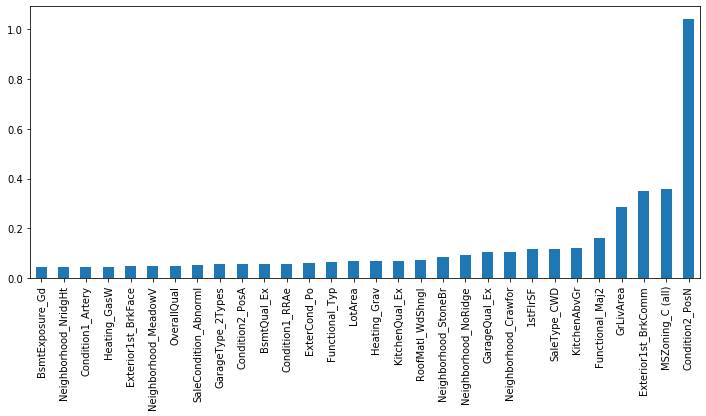

In [82]:
feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

In [83]:
#XG Boost
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.9995312283952485
Test r2 score:  0.8794429485714664
Train RMSE: 0.0087
Test RMSE: 0.1351


In [86]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse2)

Train r2 score:  0.9928421324251224
Test r2 score:  0.8793660488673074
Train RMSE: 0.0963
Test RMSE: 0.1351


In [87]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('LotArea', 108),
             ('LotFrontage', 94),
             ('MSSubClass', 69),
             ('GrLivArea', 60),
             ('OverallQual', 56),
             ('BsmtUnfSF', 55),
             ('TotalBsmtSF', 54),
             ('1stFlrSF', 43),
             ('MoSold', 39),
             ('OverallCond', 37),
             ('BsmtFinSF1', 37),
             ('GarageArea', 36),
             ('YearBuilt', 35),
             ('YearRemodAdd', 33),
             ('OpenPorchSF', 31),
             ('WoodDeckSF', 27),
             ('MasVnrArea', 27),
             ('GarageYrBlt', 26),
             ('2ndFlrSF', 22),
             ('EnclosedPorch', 15),
             ('YrSold', 14),
             ('TotRmsAbvGrd', 14),
             ('ScreenPorch', 13),
             ('GarageCars', 12),
             ('GarageType_Attchd', 10),
             ('Fireplaces', 9),
             ('BedroomAbvGr', 9),
             ('SaleCondition_Abnorml', 9),
             ('BsmtFinSF2', 8),
             ('BsmtFullBath', 

In [89]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
most_relevant_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'MSZoning_C (all)',
 '1stFlrSF',
 'Fireplaces',
 'YearRemodAdd',
 'OverallCond',
 'OpenPorchSF',
 'LotArea',
 'YearBuilt',
 'BsmtFinSF1',
 'LotFrontage',
 'GarageType_Attchd',
 'FullBath',
 'GarageQual_TA',
 'FireplaceQu_Po',
 'BsmtUnfSF',
 'BsmtFullBath',
 'GarageYrBlt',
 'Functional_Typ',
 'KitchenAbvGr',
 'MSSubClass',
 'BedroomAbvGr',
 'GarageArea',
 'MoSold',
 'Condition1_Norm',
 'SaleCondition_Abnorml',
 'WoodDeckSF',
 'EnclosedPorch',
 'BsmtExposure_Gd',
 'Neighborhood_Edwards',
 'SaleType_COD',
 'Condition1_Artery',
 'Neighborhood_Crawfor',
 'SaleType_New',
 '2ndFlrSF',
 'Neighborhood_NAmes',
 'MasVnrArea',
 'RoofStyle_Gable',
 'YrSold',
 'BsmtFinType1_ALQ',
 'ScreenPorch',
 'BsmtFinType1_Rec',
 'FireplaceQu_Gd',
 'TotRmsAbvGrd',
 'ExterQual_Gd',
 'MasVnrType_BrkFace',
 'BsmtFinSF2',
 'HouseStyle_SLvl',
 'LotConfig_Corner',
 'HeatingQC_TA',
 'GarageFinish_RFn',
 'KitchenQual_Ex',
 'BsmtFinType2_BLQ',
 'HalfBath',
 'E

In [90]:
train_x=df[most_relevant_features]
train_y=df['SalePrice']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

Train r2 score:  0.984720006304141
Test r2 score:  0.8749401528325247
Train RMSE: 0.0487
Test RMSE: 0.1376
